In [1]:
import re
import nltk
import textstat
import pandas as pd
import numpy as np
import datetime
import statsmodels.api as sm
from collections import Counter
from scipy.stats import mannwhitneyu
import matplotlib.pyplot as plt
import pymongo

nltk.download("wordnet")
nltk.download("omw-1.4")

[nltk_data] Downloading package wordnet to E:\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to E:\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [2]:
def connect_mongo(query={},host='localhost', port=27017, username=None, password=None, db='test'):
    if username and password:
        mongo_uri = "mongodb://%s:%s@%s:%s/%s" % (username, password, host, port, db)
        client = pymongo.MongoClient(mongo_uri)
    else:
        client = pymongo.MongoClient(host, port)
    return client
    
client = connect_mongo()
collect = client.issues.first_issues
tmp_collect = client.gfibot.resolved_issue
# db = collect.find({"resolver_commit_num":{"$gte": 0, "$lte": 2}}).sort("closed_at",pymongo.ASCENDING)

In [3]:
df = pd.DataFrame(list(collect.find()))

In [4]:
otc = set()
cnt = 0
for data in collect.find():
    if tmp_collect.count_documents({"owner":data["owner"],"name":data["name"],"resolver":data["resolver"]}) <= 1:
#         print(data["owner"], data["name"], data["resolver"],tmp_collect.count_documents({"owner":data["owner"],"name":data["name"],"resolver":data["resolver"]}))
        otc.add(data["owner"]+"/"+data["name"]+"/"+data["resolver"])
    else:
        res = tmp_collect.find({"owner":data["owner"],"name":data["name"],"resolver":data["resolver"]}).sort([("resolved_at",-1)]).limit(1)
        for item in res:
            if (item["resolved_at"]-data["closed_at"]).days<7:
                otc.add(item["owner"]+"/"+item["name"]+"/"+item["resolver"])

In [5]:
len(otc)

8779

In [65]:
otc_iss, notc_iss = df[(df.owner+"/"+df.name+"/"+df.resolver).isin(otc)], df[~(df.owner+"/"+df.name+"/"+df.resolver).isin(otc)]

In [7]:
len(otc_iss), len(notc_iss)

(11308, 3633)

In [60]:
same1 = list(x if otc_iss.loc[x].reporter_feat["name"] == otc_iss.loc[x].resolver else 0 for x in otc_iss.index)
same2 = list(1 if notc_iss.loc[x].reporter_feat["name"] == notc_iss.loc[x].resolver else 0 for x in notc_iss.index)
same1 = otc_iss.iloc[same1]
same2 = notc_iss.iloc[same2]

SyntaxError: invalid syntax (<ipython-input-60-5297bc7127e5>, line 1)

In [71]:
same1 = []
not_same1 = []
for index,item in otc_iss.iterrows():
    if item.reporter_feat["name"] == item.resolver:
        same1.append(index)
    else:
        not_same1.append(index)

same2 = []
not_same2 = []
for index,item in notc_iss.iterrows():
    if item.reporter_feat["name"] == item.resolver:
        same2.append(index)
    else:
        not_same2.append(index)

In [79]:
otc_iss = df.iloc[not_same1]
notc_iss = df.iloc[not_same2]
# len(otc_iss), len(notc_iss)

In [47]:
metrics = [
    "len_title", "len_body", 
    "n_code_snips", "n_urls", "n_imgs", 
    "changed_files","additions","deletions",
    "coleman_liau_index", 
    "flesch_reading_ease", "flesch_kincaid_grade", "automated_readability_index",     
]

In [80]:
otc_iss[metrics].describe()

,len_title,len_body,n_code_snips,n_urls,n_imgs,changed_files,additions,deletions,coleman_liau_index,flesch_reading_ease,flesch_kincaid_grade,automated_readability_index
count,6984.000000,6984.000000,6984.000000,6984.000000,6984.000000,6984.000000,6984.000000,6984.000000,6984.000000,6984.000000,6984.000000,6984.000000
mean,7.603093,95.999141,0.642898,1.461770,0.012457,4.968213,182.080899,128.353666,17.431297,48.254038,9.947466,18.475773
std,3.264417,97.882174,1.175395,3.883411,0.140536,22.654516,3555.092166,3748.021113,36.544889,94.474124,13.220926,34.137778
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-28.010000,-4550.100000,-15.700000,-6.900000
25%,5.000000,35.000000,0.000000,0.000000,0.000000,1.000000,3.000000,1.000000,9.667500,44.592500,6.800000,10.300000
50%,7.000000,69.000000,0.000000,1.000000,0.000000,2.000000,14.000000,3.000000,12.490000,58.280000,8.700000,13.500000
75%,9.000000,131.000000,1.000000,2.000000,0.000000,4.000000,55.000000,12.000000,16.762500,68.770000,11.100000,18.000000
max,32.000000,2504.000000,14.000000,274.000000,6.000000,1054.000000,214919.000000,209823.000000,1925.410000,206.840000,650.600000,1609.300000


In [81]:
notc_iss[metrics].describe()

,len_title,len_body,n_code_snips,n_urls,n_imgs,changed_files,additions,deletions,coleman_liau_index,flesch_reading_ease,flesch_kincaid_grade,automated_readability_index
count,2640.000000,2640.000000,2640.000000,2640.000000,2640.000000,2640.000000,2640.000000,2640.000000,2640.000000,2640.000000,2640.000000,2640.000000
mean,7.644318,91.150758,0.598106,1.270076,0.012121,5.261364,299.573864,207.979545,15.649621,53.836420,9.212159,16.924129
std,3.294961,84.489663,1.081483,2.012507,0.145166,18.577528,4356.517775,3711.103744,17.605757,47.347514,7.076188,17.675114
min,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,-15.810000,-978.590000,-15.700000,-4.400000
25%,5.000000,33.000000,0.000000,0.000000,0.000000,1.000000,4.000000,1.000000,9.500000,44.410000,6.600000,10.200000
50%,7.000000,67.000000,0.000000,1.000000,0.000000,2.000000,16.000000,3.000000,12.640000,58.890000,8.600000,13.600000
75%,9.000000,127.000000,1.000000,2.000000,0.000000,4.000000,62.250000,13.000000,17.085000,69.590000,11.100000,18.400000
max,34.000000,845.000000,10.000000,61.000000,3.000000,278.000000,150981.000000,119792.000000,291.300000,206.840000,150.000000,295.100000


In [82]:
for metric in metrics:
    print(f"{metric:30} {mannwhitneyu(otc_iss[metric], notc_iss[metric])}")

len_title                      MannwhitneyuResult(statistic=9145766.5, pvalue=0.27281179780102127)
len_body                       MannwhitneyuResult(statistic=8998693.0, pvalue=0.03509738783582782)
n_code_snips                   MannwhitneyuResult(statistic=9128507.0, pvalue=0.18827741219424488)
n_urls                         MannwhitneyuResult(statistic=8847829.0, pvalue=0.0007095696752232771)
n_imgs                         MannwhitneyuResult(statistic=9205564.5, pvalue=0.26018519198172285)
changed_files                  MannwhitneyuResult(statistic=8815862.0, pvalue=0.00027700486255563506)
additions                      MannwhitneyuResult(statistic=8825702.0, pvalue=0.0006028416995751831)
deletions                      MannwhitneyuResult(statistic=9077482.0, pvalue=0.1205787204072904)
coleman_liau_index             MannwhitneyuResult(statistic=9194832.5, pvalue=0.42162365630162174)
flesch_reading_ease            MannwhitneyuResult(statistic=9040032.5, pvalue=0.07068854268219525)
fles

In [83]:
list(map(
    lambda x: (x[0], x[1] / len(otc_iss)), 
    sorted(Counter(sum(otc_iss.labels, [])).items(), key=lambda x: -x[1])[0:20]
))

[('good first issue', 0.22623138602520046),
 ('help wanted', 0.15721649484536082),
 ('bug', 0.10380870561282933),
 ('Bug', 0.07073310423825888),
 ('enhancement', 0.05942153493699885),
 ('Easy', 0.027920962199312716),
 ('Effort Low', 0.02720504009163803),
 ('Docs', 0.0259163802978236),
 ('Documentation', 0.025057273768613976),
 ('easy', 0.024484536082474227),
 ('<Bug>', 0.024054982817869417),
 ('hacktoberfest', 0.022336769759450172),
 ('up-for-grabs', 0.021620847651775486),
 ('Hacktoberfest', 0.021191294387170677),
 ('Good First Issue', 0.01961626575028637),
 ('confirmed', 0.018470790378006873),
 ('feature-request', 0.016609392898052692),
 ('accepted', 0.016179839633447882),
 ('first-timers-only', 0.01575028636884307),
 ('docs', 0.015607101947308133)]

In [84]:
list(map(
    lambda x: (x[0], x[1] / len(notc_iss)), 
    sorted(Counter(sum(notc_iss.labels, [])).items(), key=lambda x: -x[1])[0:20]
))

[('good first issue', 0.24696969696969698),
 ('bug', 0.14962121212121213),
 ('help wanted', 0.13106060606060607),
 ('Bug', 0.07537878787878788),
 ('enhancement', 0.06287878787878788),
 ('feature-request', 0.03068181818181818),
 ('Good First Issue', 0.028409090909090908),
 ('Effort Low', 0.025757575757575757),
 ('Easy', 0.025),
 ('in progress', 0.021212121212121213),
 ('<Bug>', 0.020075757575757577),
 ('Hacktoberfest', 0.019696969696969695),
 ('easy', 0.019318181818181818),
 ('Documentation', 0.01893939393939394),
 ('Docs', 0.017803030303030303),
 ('Needs Tests', 0.017424242424242425),
 ('effort/small', 0.016666666666666666),
 ('Easy to Fix', 0.015909090909090907),
 ('beta', 0.014772727272727272),
 ('confirmed', 0.014393939393939395)]

In [85]:
counter1 = Counter()
for cat in otc_iss.label_category:
    counter1.update(cat)
total = sum(counter1.values())
for k, v in counter1.items():
    counter1[k] = v / total
counter1

Counter({'bug': 0.2118139739916244,
         'feature': 0.049041216662993166,
         'test': 0.023253251046947324,
         'build': 0.011130703107780473,
         'doc': 0.08287414591139519,
         'coding': 0.01796341194621997,
         'enhance': 0.07416795239144809,
         'gfi': 0.3966277275732863,
         'medium': 0.018514436852545734,
         'major': 0.04771875688781133,
         'triaged': 0.05862905003306149,
         'untriaged': 0.008265373594886488})

In [86]:
counter2 = Counter()
for cat in notc_iss.label_category:
    counter2.update(cat)
total = sum(counter2.values())
for k, v in counter2.items():
    counter2[k] = v / total
counter2

Counter({'bug': 0.24455275229357798,
         'feature': 0.06077981651376147,
         'test': 0.024655963302752295,
         'build': 0.016341743119266054,
         'doc': 0.05762614678899083,
         'coding': 0.023509174311926607,
         'enhance': 0.07597477064220183,
         'gfi': 0.38102064220183485,
         'medium': 0.01548165137614679,
         'major': 0.034403669724770644,
         'triaged': 0.05676605504587156,
         'untriaged': 0.008887614678899083})

Text(0, 0.5, 'ratio')

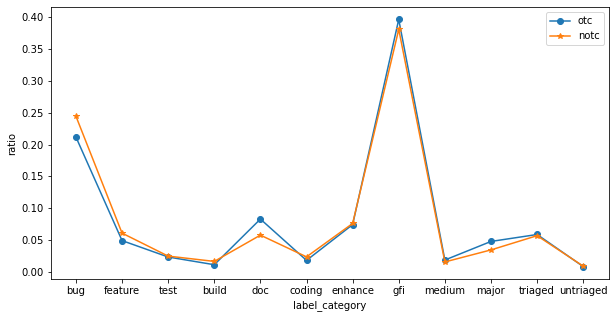

In [87]:
plt.figure(figsize=(10,5))
x_counter = counter1.keys()
y_counter1 = counter1.values()
y_counter2 = counter2.values()

plt.plot(x_counter, y_counter1, marker='o',label='otc')
plt.plot(x_counter, y_counter2, marker='*',label='notc')
plt.legend()  # 让图例生效
 
# 显示标签，如果不加这句，即使在plot中加了label='一些数字'的参数，最终还是不会显示标签
plt.legend(loc="upper right")
plt.xlabel('label_category')
plt.ylabel('ratio')

In [88]:
otc_events = dict(map(
    lambda x: (x[0], x[1] / len(otc_iss)), 
    sorted(Counter(sum(otc_iss.events, [])).items(), key=lambda x: -x[1])[0:20]
))

In [89]:
notc_events = dict(map(
    lambda x: (x[0], x[1] / len(notc_iss)), 
    sorted(Counter(sum(notc_iss.events, [])).items(), key=lambda x: -x[1])[0:20]
))

In [120]:
x_counter = otc_events.keys()
list(set(x_counter) | set(x_counter1))

['labeled',
 'removed_from_project',
 'subscribed',
 'mentioned',
 'unassigned',
 'unsubscribed',
 'reopened',
 'milestoned',
 'transferred',
 'moved_columns_in_project',
 'assigned',
 'unlabeled',
 'commented',
 'cross-referenced',
 'referenced',
 'demilestoned',
 'comment_deleted',
 'connected',
 'closed',
 'added_to_project',
 'renamed']

False


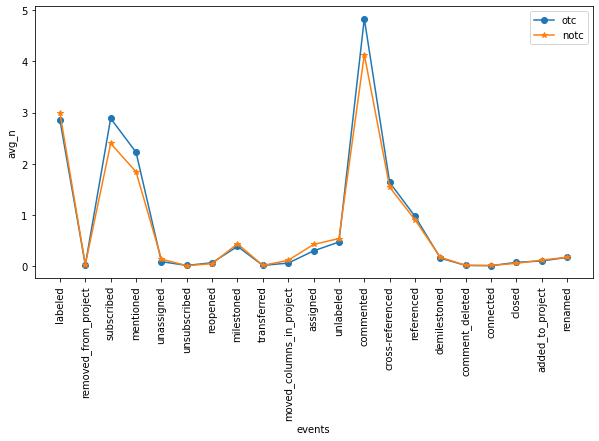

In [125]:
plt.figure(figsize=(10,5))
# x轴
x_counter = otc_events.keys()
x_counter1 = notc_events.keys()
print(x_counter == x_counter1)
x_counter = list(set(x_counter) | set(x_counter1))
# y轴
# y_counter1 = otc_events.values()
# y_counter2 = [notc_events[key] for key in x_counter]
y_counter1 = [(otc_events[key] if key in otc_events.keys() else 0) for key in x_counter]
y_counter2 = [(notc_events[key] if key in notc_events.keys() else 0) for key in x_counter]

plt.plot(x_counter, y_counter1, marker='o',label='otc')
plt.plot(x_counter, y_counter2, marker='*',label='notc')
plt.legend()  # 让图例生效
 
plt.legend(loc="upper right")
plt.xlabel('events')
plt.ylabel('avg_n')
res = plt.xticks(rotation=90)

In [20]:
same1 = list(1 if otc_iss.loc[x].reporter_feat["name"] == otc_iss.loc[x].resolver else 0 for x in otc_iss.index)
same2 = list(1 if notc_iss.loc[x].reporter_feat["name"] == notc_iss.loc[x].resolver else 0 for x in notc_iss.index)

In [21]:
print(sum(same1)/len(same1),sum(same2)/len(same2))
print(mannwhitneyu(same1, same2))

0.38238415281216837 0.27332782824112306
MannwhitneyuResult(statistic=18300858.0, pvalue=3.4999513410890144e-33)


In [ ]:
# issue所在项目的差别

In [92]:
metrics_bg = [
    "n_stars", "n_pulls", "n_commits", "n_contributors", "n_closed_issues", "n_open_issues", "r_open_issues"
]

In [93]:
otc_iss[metrics_bg].describe()

,n_stars,n_pulls,n_commits,n_contributors,n_closed_issues,n_open_issues,r_open_issues
count,6984.000000,6984.000000,6984.000000,6984.000000,6984.000000,6984.000000,6984.000000
mean,15340.775916,6998.286369,17067.909937,686.555985,6694.548826,1055.101947,0.169071
std,14994.676453,8166.128606,18868.668914,770.312350,8298.812853,1441.318154,0.125628
min,2.000000,0.000000,0.000000,0.000000,13.000000,3.000000,0.002971
25%,2372.000000,1831.500000,4671.500000,167.000000,1657.000000,229.000000,0.068831
50%,8421.000000,4027.500000,11286.000000,410.500000,4186.000000,519.000000,0.165004
75%,28475.000000,9163.750000,21592.000000,953.250000,9837.250000,1263.500000,0.221075
max,40019.000000,87768.000000,111911.000000,4371.000000,100384.000000,29622.000000,0.996344


In [94]:
notc_iss[metrics_bg].describe()

,n_stars,n_pulls,n_commits,n_contributors,n_closed_issues,n_open_issues,r_open_issues
count,2640.000000,2640.000000,2640.000000,2640.000000,2640.000000,2640.000000,2640.000000
mean,13767.013636,7536.609470,17348.934848,648.001894,7298.546591,1280.066288,0.190764
std,14628.620919,9715.475121,18622.023522,763.891933,9398.367266,1612.064990,0.140279
min,0.000000,22.000000,0.000000,0.000000,1.000000,1.000000,0.005950
25%,1910.000000,1677.000000,4456.750000,131.000000,1541.750000,245.750000,0.096770
50%,6422.000000,4178.000000,11376.000000,364.000000,4153.000000,646.500000,0.178510
75%,24816.000000,9482.000000,22977.000000,840.250000,9818.000000,1658.000000,0.238900
max,40019.000000,88678.000000,113062.000000,4358.000000,118634.000000,29552.000000,0.993411


In [95]:
for metric in metrics_bg:
    print(f"{metric:30} {mannwhitneyu(otc_iss[metric], notc_iss[metric])}")
# otc选的项目star，contributors 更多
# notc选的项目commits，open issue数，open issue比例 更多
# 更新：子数据集commit没有显著差异了

n_stars                        MannwhitneyuResult(statistic=8750866.0, pvalue=5.873156170541482e-05)
n_pulls                        MannwhitneyuResult(statistic=9153991.5, pvalue=0.2968154350167257)
n_commits                      MannwhitneyuResult(statistic=9091114.0, pvalue=0.1467140415051978)
n_contributors                 MannwhitneyuResult(statistic=8790647.5, pvalue=0.00021463520812923137)
n_closed_issues                MannwhitneyuResult(statistic=9139458.5, pvalue=0.2568498557317336)
n_open_issues                  MannwhitneyuResult(statistic=8487870.5, pvalue=9.209374136268149e-10)
r_open_issues                  MannwhitneyuResult(statistic=8378202.5, pvalue=2.3728732594231297e-12)


In [84]:
file_type_lst = []
for index, data in otc_iss.iterrows():
    for i in data["changed_files_list"]:
        if "/" in i[0].split(".")[-1]:
            print(i[0])
            continue
        if i[0].split(".")[-1] not in file_type_lst:            
            file_type_lst.append(i[0].split(".")[-1])
print(file_type_lst)

examples/using-square-payments/LICENSE
bin/next-init
bin/next-dev
packages/next/client/portal/LICENSE
packages/create-next-app/templates/default/gitignore
tests/templates/test_all_templates
lib/plugins/create/templates/aws-java-gradle/gradlew
lib/plugins/create/templates/kubeless-nodejs/gitignore
lib/plugins/create/templates/kubeless-python/gitignore
lib/plugins/create/templates/aws-go-dep/Makefile
lib/plugins/create/templates/aws-go-dep/gitignore
lib/plugins/create/templates/aws-go/Makefile
lib/plugins/create/templates/aws-go/gitignore
tests/templates/integration-test-template
tests/templates/test_all_templates
lib/plugins/create/templates/webtasks-nodejs/gitignore
tests/templates/test_all_templates
lib/plugins/create/templates/aws-ruby/gitignore
tests/templates/test_all_templates
lib/plugins/create/templates/azure-nodejs-typescript/gitignore
tools/deployment/osqueryctl
dockerfiles/full/Dockerfile
dockerfiles/mingw-arch/Dockerfile
dockerfiles/ubuntu_amd64/Dockerfile
dockerfiles/ubuntu

In [96]:
otc_languages = dict(map(
    lambda x: (x[0], x[1] / len(otc_iss)), 
    sorted(Counter(otc_iss.language).items(), key=lambda x: -x[1])
))
notc_languages = dict(map(
    lambda x: (x[0], x[1] / len(notc_iss)), 
    sorted(Counter(notc_iss.language).items(), key=lambda x: -x[1])
))

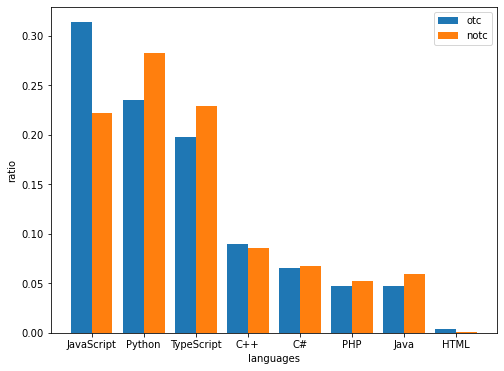

In [97]:
x_counter = np.arange(len(otc_languages.keys()))
y_counter1 = otc_languages.values()
y_counter2 = [notc_languages[key] for key in otc_languages.keys()]

plt.figure(figsize=(8, 6))
plt.bar(x_counter-0.2, y_counter1, width=0.4, align='center', label='otc')
plt.bar(x_counter+0.2, y_counter2, width=0.4, align='center', label='notc')
plt.xlabel('languages')
plt.ylabel('ratio')
plt.xticks(x_counter, otc_languages.keys())
plt.legend()
plt.show()

# 语言

In [ ]:
# 选择一部分issue进行人工查看

In [18]:
np.random.seed(0)
rand1 = np.random.randint(0, len(otc_iss), size=int(0.01*len(otc_iss)))
rand2 = np.random.randint(0, len(notc_iss), size=int(0.03*len(notc_iss)))

otc_selected = otc_iss.iloc[rand1].copy()
notc_selected = notc_iss.iloc[rand2].copy()

otc_selected['url'] = "https://github.com/" + otc_selected['owner'] + "/" + otc_selected['name'] + "/issues/" + otc_selected['number'].astype(str)
notc_selected['url'] = "https://github.com/" + notc_selected['owner'] + "/" + notc_selected['name'] + "/issues/" + notc_selected['number'].astype(str)

In [21]:
otc_selected = otc_selected[['owner','name','number','resolver','url']]
notc_selected = notc_selected[['owner','name','number','resolver','url']]

In [22]:
# otc_selected.to_csv('../data/otc_selected.csv', index=False, header=True)
with pd.ExcelWriter('../data/selected_iss.xls') as writer:
    otc_selected.to_excel(writer, sheet_name='otc', index=False, header=True)
    notc_selected.to_excel(writer, sheet_name='notc', index=False, header=True)

In [ ]:
# 选notc issue多的项目

In [98]:
print(len(notc_iss))
dict(map(
lambda x: (x[0], x[1]), 
sorted(Counter(notc_iss.owner+"/"+notc_iss.name).items(), key=lambda x: -x[1])[0:10]
))

2640


{'pandas-dev/pandas': 257,
 'freeCodeCamp/freeCodeCamp': 211,
 'CleverRaven/Cataclysm-DDA': 141,
 'mui/material-ui': 115,
 'scikit-learn/scikit-learn': 97,
 'Yoast/wordpress-seo': 86,
 'microsoft/vscode': 86,
 'sympy/sympy': 80,
 'aws/aws-cdk': 78,
 'zulip/zulip': 69}

In [99]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def plot_word_cloud(s):
    s = s.lower()
#     print(s)
    wordcloud = WordCloud(background_color="white",\
                      width = 400,\
                      height = 300,\
                      max_font_size = 80,\
                      contour_width = 3,\
                      contour_color = 'steelblue'
                      ).generate(s)
#                       ).generate_from_frequencies(dic1)
    plt.figure(figsize=(13,7))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()
    
def plot_notc_iss_body(owner:str, name:str) -> None:
    tmp_df = notc_iss[(notc_iss.owner == owner) & (notc_iss.name == name)]
    s = tmp_df.body.sum()     
    s = re.sub(r'```.*\n([\s\S]*?)```', '', s)# 去除代码块   
    s = re.sub(r'!\[.*\]\(.*\)', '', s)# 去除图片    
    s = re.sub(r'\[.*\]\(.*\)', '', s)# 去除链接   
    s = re.sub(r'#+ .*', '', s) # 去除标题
    s = re.sub(r'[*_~`>|]', '', s) # 去除标题
    plot_word_cloud(s)

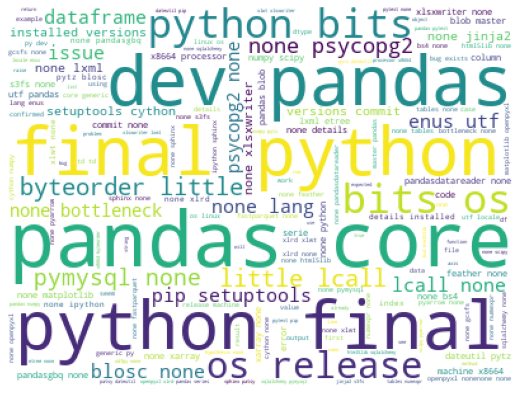

In [100]:
plot_notc_iss_body('pandas-dev', 'pandas')

In [101]:
tmp_df = notc_iss[(notc_iss.owner == "pandas-dev") & (notc_iss.name == "pandas")]
print("notc code snips:", sum(tmp_df.n_code_snips), sum(tmp_df.n_code_snips)/len(tmp_df))
print("notc urls:", sum(tmp_df.n_urls), sum(tmp_df.n_urls)/len(tmp_df))
print("notc imgs:", sum(tmp_df.n_imgs), sum(tmp_df.n_imgs)/len(tmp_df))
tmp_df = otc_iss[(otc_iss.owner == "pandas-dev") & (otc_iss.name == "pandas")]
print("otc code snips:", sum(tmp_df.n_code_snips), sum(tmp_df.n_code_snips)/len(tmp_df))
print("otc urls:", sum(tmp_df.n_urls), sum(tmp_df.n_urls)/len(tmp_df))
print("otc imgs:", sum(tmp_df.n_imgs), sum(tmp_df.n_imgs)/len(tmp_df))

notc code snips: 404 1.5719844357976653
notc urls: 243 0.9455252918287937
notc imgs: 0 0.0
otc code snips: 879 1.4898305084745762
otc urls: 517 0.8762711864406779
otc imgs: 6 0.010169491525423728


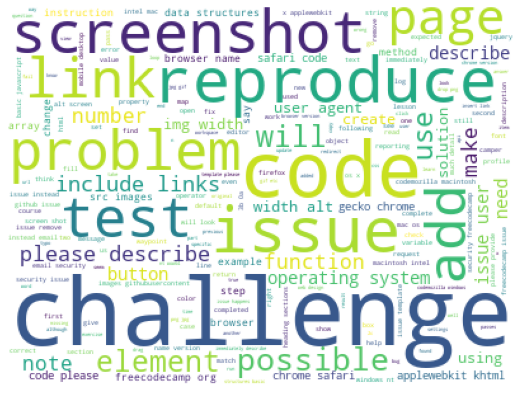

In [102]:
plot_notc_iss_body('freeCodeCamp', 'freeCodeCamp')

In [25]:
tmp_df = notc_iss[(notc_iss.owner == "freeCodeCamp") & (notc_iss.name == "freeCodeCamp")]
print("notc code snips:", sum(tmp_df.n_code_snips), sum(tmp_df.n_code_snips)/len(tmp_df))
print("notc urls:", sum(tmp_df.n_urls), sum(tmp_df.n_urls)/len(tmp_df))
print("notc imgs:", sum(tmp_df.n_imgs), sum(tmp_df.n_imgs)/len(tmp_df))
tmp_df = otc_iss[(otc_iss.owner == "freeCodeCamp") & (otc_iss.name == "freeCodeCamp")]
print("otc code snips:", sum(tmp_df.n_code_snips), sum(tmp_df.n_code_snips)/len(tmp_df))
print("otc urls:", sum(tmp_df.n_urls), sum(tmp_df.n_urls)/len(tmp_df))
print("otc imgs:", sum(tmp_df.n_imgs), sum(tmp_df.n_imgs)/len(tmp_df))

notc code snips: 87 0.35080645161290325
notc urls: 371 1.4959677419354838
notc imgs: 13 0.05241935483870968
otc code snips: 323 0.4261213720316623
otc urls: 1429 1.8852242744063326
otc imgs: 33 0.04353562005277045


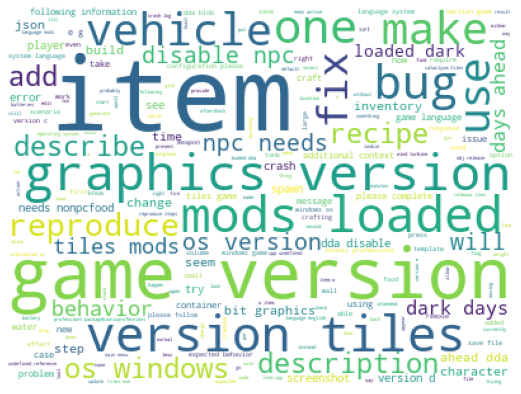

In [67]:
plot_notc_iss_body('CleverRaven', 'Cataclysm-DDA')

In [27]:
tmp_df = notc_iss[(notc_iss.owner == "CleverRaven") & (notc_iss.name == "Cataclysm-DDA")]
print("notc code snips:", sum(tmp_df.n_code_snips), sum(tmp_df.n_code_snips)/len(tmp_df))
print("notc urls:", sum(tmp_df.n_urls), sum(tmp_df.n_urls)/len(tmp_df))
print("notc imgs:", sum(tmp_df.n_imgs), sum(tmp_df.n_imgs)/len(tmp_df))
tmp_df = otc_iss[(otc_iss.owner == "CleverRaven") & (otc_iss.name == "Cataclysm-DDA")]
print("otc code snips:", sum(tmp_df.n_code_snips), sum(tmp_df.n_code_snips)/len(tmp_df))
print("otc urls:", sum(tmp_df.n_urls), sum(tmp_df.n_urls)/len(tmp_df))
print("otc imgs:", sum(tmp_df.n_imgs), sum(tmp_df.n_imgs)/len(tmp_df))

notc code snips: 25 0.13966480446927373
notc urls: 168 0.9385474860335196
notc imgs: 3 0.01675977653631285
otc code snips: 39 0.0745697896749522
otc urls: 380 0.7265774378585086
otc imgs: 15 0.028680688336520075


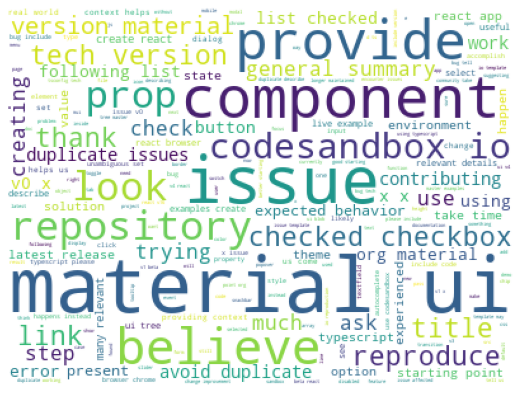

In [68]:
plot_notc_iss_body('mui', 'material-ui')

In [26]:
tmp_df = notc_iss[(notc_iss.owner == "mui") & (notc_iss.name == "material-ui")]
print("notc code snips:", sum(tmp_df.n_code_snips), sum(tmp_df.n_code_snips)/len(tmp_df))
print("notc urls:", sum(tmp_df.n_urls), sum(tmp_df.n_urls)/len(tmp_df))
print("notc imgs:", sum(tmp_df.n_imgs), sum(tmp_df.n_imgs)/len(tmp_df))
tmp_df = otc_iss[(otc_iss.owner == "mui") & (otc_iss.name == "material-ui")]
print("otc code snips:", sum(tmp_df.n_code_snips), sum(tmp_df.n_code_snips)/len(tmp_df))
print("otc urls:", sum(tmp_df.n_urls), sum(tmp_df.n_urls)/len(tmp_df))
print("otc imgs:", sum(tmp_df.n_imgs), sum(tmp_df.n_imgs)/len(tmp_df))

notc code snips: 90 0.5487804878048781
notc urls: 431 2.6280487804878048
notc imgs: 0 0.0
otc code snips: 385 0.511968085106383
otc urls: 1888 2.5106382978723403
otc imgs: 4 0.005319148936170213


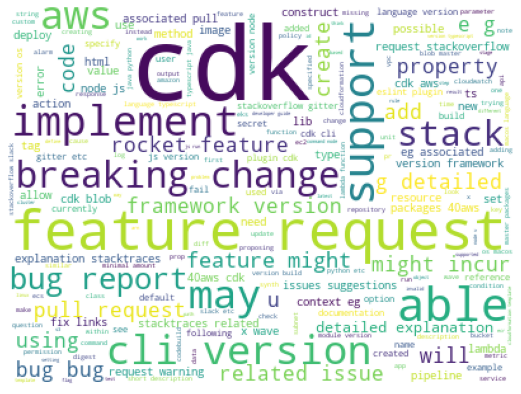

In [8]:
plot_notc_iss_body('aws', 'aws-cdk')

In [30]:
tmp_df = notc_iss[(notc_iss.owner == "aws") & (notc_iss.name == "aws-cdk")]
with pd.ExcelWriter('../data/test.xls') as writer:
    tmp_df.to_excel(writer, index=False, header=True)

In [137]:
notc_iss_same = df.iloc[not_same2]

In [155]:
notc_same = []
for index, item in notc_iss_same.iterrows():
    notc_same.append((item.owner, item["name"], item.resolver))

In [158]:
tmp_collection = client.gfibot.resolved_issue
dic_later_iss = {}
for item in notc_same:
    cnt = tmp_collection.find({"owner":item[0],"name":item[1],"resolver":item[2]}).count() - 1
    dic_later_iss[cnt] = dic_later_iss[cnt] + 1 if cnt in dic_later_iss.keys() else 1
print(dic_later_iss)

<ipython-input-158-8acff3ac5562>:4: DeprecationWarning: count is deprecated. Use Collection.count_documents instead.
  cnt = tmp_collection.find({"owner":item[0],"name":item[1],"resolver":item[2]}).count() - 1


{10: 66, 1: 658, 3: 230, 4: 168, 8: 45, 2: 389, 6: 109, 5: 102, 381: 1, 376: 18, 128: 1, 9: 45, 37: 28, 35: 5, 21: 11, 12: 33, 19: 13, 153: 2, 14: 22, 11: 32, 29: 2, 13: 19, 20: 25, 16: 18, 184: 1, 33: 7, 17: 10, 18: 7, 7: 48, 23: 5, 103: 1, 22: 17, 59: 4, 46: 7, 50: 7, 52: 4, 34: 2, 51: 3, 135: 3, 148: 2, 81: 5, 77: 1, 44: 6, 60: 1, 169: 1, 53: 3, 49: 2, 56: 5, 63: 3, 159: 1, 24: 14, 175: 1, 82: 5, 26: 11, 15: 20, 108: 1, 25: 17, 39: 33, 48: 3, 69: 3, 172: 2, 145: 26, 36: 3, 170: 1, 78: 1, 93: 2, 67: 2, 28: 5, 541: 1, 73: 2, 30: 6, 207: 66, 308: 4, 138: 1, 79: 1, 209: 1, 205: 1, 327: 1, 248: 2, 31: 4, 195: 2, 27: 14, 95: 10, 126: 1, 324: 1, 72: 1, 38: 3, 112: 1, 41: 1, 55: 4, 167: 1, 54: 6, 61: 1, 64: 2, 142: 1, 124: 1, 74: 1, 165: 1, 234: 1, 160: 1, 47: 1, 161: 1, 83: 1, 80: 1, 181: 1, 147: 1, 151: 1, 43: 6, 100: 1, 257: 3, 45: 3, 102: 66, 86: 2, 109: 2, 42: 2, 537: 1, 68: 2, 141: 1, 262: 1, 32: 1, 40: 1, 1657: 1, 91: 44, 75: 2, 117: 1, 437: 1}


In [164]:
dic_later_iss = sorted(dic_later_iss.items(),key=lambda x: x[0],reverse=True)


[(1657, 1),
 (541, 1),
 (537, 1),
 (437, 1),
 (381, 1),
 (376, 18),
 (327, 1),
 (324, 1),
 (308, 4),
 (262, 1),
 (257, 3),
 (248, 2),
 (234, 1),
 (209, 1),
 (207, 66),
 (205, 1),
 (195, 2),
 (184, 1),
 (181, 1),
 (175, 1),
 (172, 2),
 (170, 1),
 (169, 1),
 (167, 1),
 (165, 1),
 (161, 1),
 (160, 1),
 (159, 1),
 (153, 2),
 (151, 1),
 (148, 2),
 (147, 1),
 (145, 26),
 (142, 1),
 (141, 1),
 (138, 1),
 (135, 3),
 (128, 1),
 (126, 1),
 (124, 1),
 (117, 1),
 (112, 1),
 (109, 2),
 (108, 1),
 (103, 1),
 (102, 66),
 (100, 1),
 (95, 10),
 (93, 2),
 (91, 44),
 (86, 2),
 (83, 1),
 (82, 5),
 (81, 5),
 (80, 1),
 (79, 1),
 (78, 1),
 (77, 1),
 (75, 2),
 (74, 1),
 (73, 2),
 (72, 1),
 (69, 3),
 (68, 2),
 (67, 2),
 (64, 2),
 (63, 3),
 (61, 1),
 (60, 1),
 (59, 4),
 (56, 5),
 (55, 4),
 (54, 6),
 (53, 3),
 (52, 4),
 (51, 3),
 (50, 7),
 (49, 2),
 (48, 3),
 (47, 1),
 (46, 7),
 (45, 3),
 (44, 6),
 (43, 6),
 (42, 2),
 (41, 1),
 (40, 1),
 (39, 33),
 (38, 3),
 (37, 28),
 (36, 3),
 (35, 5),
 (34, 2),
 (33, 7),
 (32

In [168]:
list(dic_later_iss.values())[len(notc_same)//2]

IndexError: list index out of range

In [167]:
len(dic_later_iss.values())

126

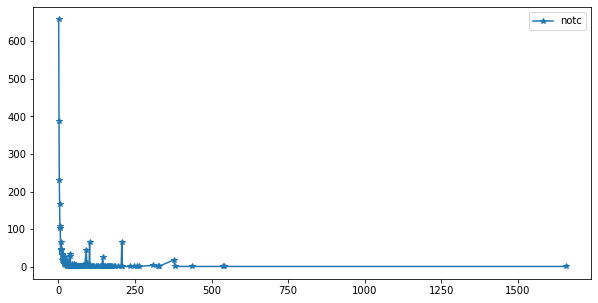

In [161]:
plt.figure(figsize=(10,5))
# x轴
x_counter = sorted(dic_later_iss.keys(),reverse = True)
# y轴
y_counter = [dic_later_iss[key] for key in x_counter]
# plt.plot(dic_later_iss, marker='o',label='otc')
plt.plot(x_counter, y_counter, marker='*',label='notc')
plt.legend()  # 让图例生效
 
# plt.legend(loc="upper right")
# plt.xlabel('events')
# plt.ylabel('avg_n')
# res = plt.xticks(rotation=90)